<a href="https://colab.research.google.com/github/Rutheeshwaran/sample/blob/main/A_model_that_works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ===================================================================
# NOTEBOOK V2: Whole Volume Classification
# ===================================================================
# CELL 1: Setup and Load Processed Data Paths
# ===================================================================
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Mount Drive and define path to our clean .npy files
print("Connecting to Google Drive...")
drive.mount('/content/drive', force_remount=True)

PROCESSED_DATA_PATH = '/content/drive/MyDrive/AI_Projects/Pancreas_CT_Data/processed_numpy'

# Check if the path exists
if not os.path.exists(PROCESSED_DATA_PATH):
    raise FileNotFoundError(f"The processed data folder was not found at: {PROCESSED_DATA_PATH}")

all_patient_files = sorted([os.path.join(PROCESSED_DATA_PATH, f) for f in os.listdir(PROCESSED_DATA_PATH) if f.endswith('.npy')])

print(f"\n✅ Found {len(all_patient_files)} processed patient scans.")

Connecting to Google Drive...
Mounted at /content/drive

✅ Found 80 processed patient scans.


In [5]:
# ===================================================================
# CELL 2: Load and Resize All 3D Volumes
# ===================================================================
from scipy.ndimage import zoom

TARGET_SHAPE = (128, 128, 128)

def resize_volume(volume, target_shape=TARGET_SHAPE):
    """Resizes a 3D volume to a target shape using zoom."""
    # Calculate the zoom factor for each dimension
    factors = (
        target_shape[0] / volume.shape[0],
        target_shape[1] / volume.shape[1],
        target_shape[2] / volume.shape[2]
    )
    # Resize the volume using linear interpolation (order=1 is fast and effective)
    resized_volume = zoom(volume, factors, order=1)
    return resized_volume

# --- Load and Resize All Volumes (This will take a few minutes) ---
X_data = []
print(f"Loading and resizing all processed volumes to shape {TARGET_SHAPE}...")
for file_path in tqdm(all_patient_files, desc="Processing Volumes"):
    volume = np.load(file_path)
    resized = resize_volume(volume)
    X_data.append(resized)

# Convert to a single NumPy array and add the channel dimension for the CNN
X_data = np.array(X_data)
X_data = np.expand_dims(X_data, axis=-1)

print(f"\n✅ Data loading and resizing complete.")
print(f"Final shape of X_data (samples, depth, height, width, channels): {X_data.shape}")

Loading and resizing all processed volumes to shape (128, 128, 128)...


Processing Volumes:   0%|          | 0/80 [00:00<?, ?it/s]


✅ Data loading and resizing complete.
Final shape of X_data (samples, depth, height, width, channels): (80, 128, 128, 128, 1)


In [6]:
# ===================================================================
# CELL 3: Create Labels and Split the Dataset
# ===================================================================
import random
from sklearn.model_selection import train_test_split

# --- We use the same simulated labels from before ---
# This ensures reproducibility.
random.seed(42)
CANCER_PATIENT_COUNT = int(len(all_patient_files) * 0.40)
cancer_indices = random.sample(range(len(all_patient_files)), CANCER_PATIENT_COUNT)
y_data = np.array([1 if i in cancer_indices else 0 for i in range(len(all_patient_files))])

print(f"Labels created: {np.sum(y_data)} cancer cases, {len(y_data) - np.sum(y_data)} normal cases.")

# --- Split the data ---
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data,
    test_size=0.2,       # 80/20 split
    random_state=42,     # For reproducibility
    stratify=y_data      # Ensure same ratio of cancer/normal in both sets
)

print("\nData successfully split:")
print(f"   - X_train shape: {X_train.shape}")
print(f"   - X_val shape: {X_val.shape}")
print(f"   - y_train shape: {y_train.shape}")
print(f"   - y_val shape: {y_val.shape}")

Labels created: 32 cancer cases, 48 normal cases.

Data successfully split:
   - X_train shape: (64, 128, 128, 128, 1)
   - X_val shape: (16, 128, 128, 128, 1)
   - y_train shape: (64,)
   - y_val shape: (16,)


In [7]:
# ===================================================================
# CELL 4 (NEW): Manual 3D Augmentation Function
# ===================================================================
from scipy.ndimage import rotate
import numpy as np

def augment_data(X_data, y_data):
    """
    Applies simple 3D augmentation by flipping and rotating the data.
    This doubles the size of the training dataset.
    """
    augmented_X = []
    augmented_y = []

    for i in range(len(X_data)):
        volume = X_data[i]
        label = y_data[i]

        # 1. Add the original volume
        augmented_X.append(volume)
        augmented_y.append(label)

        # 2. Add a horizontally flipped version
        flipped_volume = np.flip(volume, axis=2) # Flip along the width axis
        augmented_X.append(flipped_volume)
        augmented_y.append(label)

    return np.array(augmented_X), np.array(augmented_y)

print("✅ Manual augmentation function defined.")

✅ Manual augmentation function defined.


In [8]:
# ===================================================================
# CELL 5 (NEW): Apply Augmentation to Training Data
# ===================================================================

print("Applying augmentation to the training data... (This may take a moment)")
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

print("\nAugmentation complete.")
print(f"   - Original training samples: {len(X_train)}")
print(f"   - New augmented training samples: {len(X_train_augmented)}")

Applying augmentation to the training data... (This may take a moment)

Augmentation complete.
   - Original training samples: 64
   - New augmented training samples: 128


In [9]:
# ===================================================================
# CELL 6 (NEW): Build Final, Clean 3D CNN Model
# ===================================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import AdamW

def build_final_clean_cnn(input_shape):
    model = Sequential([
        # --- NO AUGMENTATION LAYERS HERE ---

        Conv3D(16, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=2),

        Conv3D(32, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=2),

        Conv3D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])

    optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Create the model
input_shape = (*TARGET_SHAPE, 1)
model = build_final_clean_cnn(input_shape)

print("✅ Final clean 3D CNN Model built successfully.")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Final clean 3D CNN Model built successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 128, 128, 128,  │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 128,  │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 64, 64, 64, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 64, 64, 64, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 32, 32, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 16, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,624,801 (128.27 MB)

 Trainable params: 33,624,577 (128.27 MB)

 Non-trainable params: 224 (896.00 B)

🚀 Starting final model training run on augmented data...
Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 300ms/step - accuracy: 0.5338 - auc: 0.5558 - loss: 11.5550 - val_accuracy: 0.4375 - val_auc: 0.5333 - val_loss: 1.0354 - learning_rate: 1.0000e-04
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.4634 - auc: 0.4964 - loss: 7.8013 - val_accuracy: 0.3750 - val_auc: 0.6917 - val_loss: 2.7360 - learning_rate: 1.0000e-04
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.6128 - auc: 0.6294 - loss: 1.3621 - val_accuracy: 0.3750 - val_auc: 0.6167 - val_loss: 3.4437 - learning_rate: 1.0000e-04
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.6946 - auc: 0.7589 - loss: 0.6036 - val_accuracy: 0.3750 - val_auc: 0.6167 - val_loss: 3.2108 - learning_rate: 1.0000e-04
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.6811 - auc: 0.7503 - loss: 0.5618 - val_accuracy: 0.3750 - val_auc: 0.6250 - val_loss: 2.8614 - learning_rate: 1.0000e

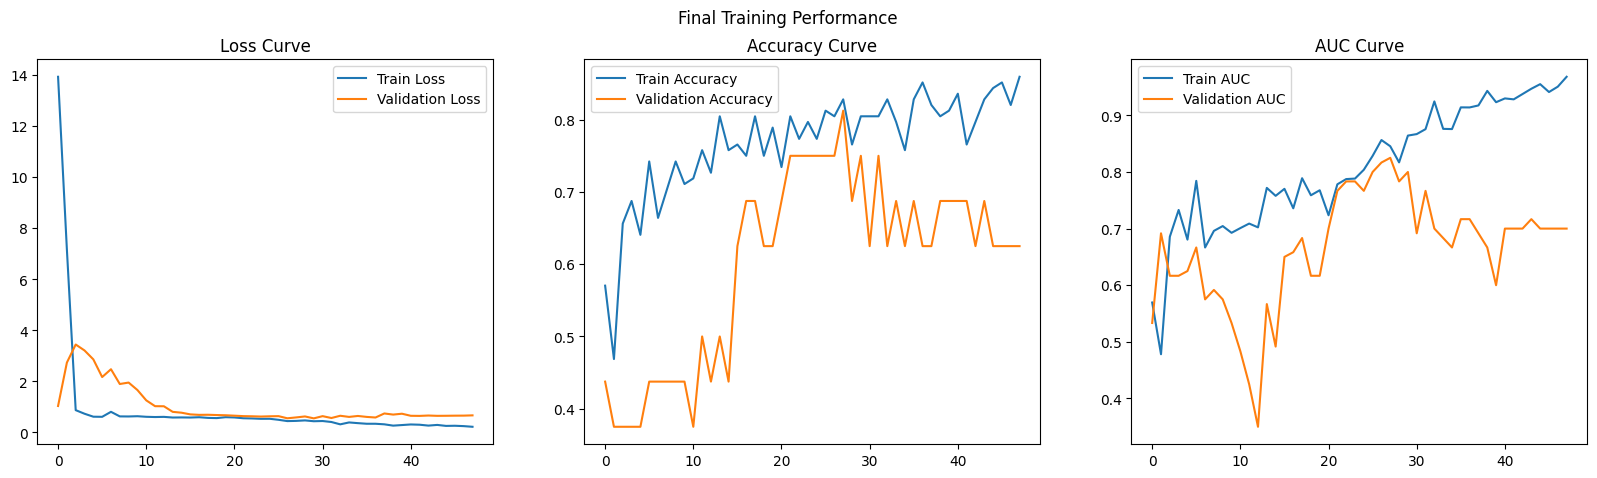

In [10]:
# ===================================================================
# CELL 7 (NEW): Train the Final Model
# ===================================================================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("🚀 Starting final model training run on augmented data...")

# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e-6, verbose=1)

epochs = 150
batch_size = 4

history = model.fit(
    X_train_augmented, y_train_augmented, # Use the new augmented data
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val), # Validation data is never augmented
    callbacks=[early_stopping, reduce_lr],
    shuffle=True # Shuffle the augmented data each epoch
)

print("\n✅ Model training finished!")

# --- VISUALIZE THE FINAL RESULTS ---
print("\nPlotting final training history...")
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Final Training Performance')
# (Plotting code is the same)
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss Curve')
axes[0].legend()
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy Curve')
axes[1].legend()
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Validation AUC')
axes[2].set_title('AUC Curve')
axes[2].legend()
plt.show()

In [ ]:
'''# My Pancreas Cancer Detection Project 🧠

Hey! You asked what I've been working on, so here's a breakdown of my deep learning project. The goal was to build an AI model that could look at 3D CT scans of a pancreas and predict whether it was cancerous or normal.

This was a super challenging but really rewarding project. Here’s how I did it.

---

## 🛠️ The Toolkit: What I Used

*   **Language:** Python
*   **"Supercomputer":** Google Colab (for the free NVIDIA GPU, which is essential!)
*   **AI Framework:** TensorFlow & Keras (for building and training the neural network)
*   **Medical Image Libraries:** `SimpleITK` & `Pydicom` (special tools to handle complex medical DICOM files)
*   **Math & Data Libraries:** `NumPy` & `SciPy` (for all the heavy-duty data manipulation)
*   **Plotting:** `Matplotlib` (for creating the final graphs)

---

## 🗺️ The Step-by-Step Journey

This project was a rollercoaster. Here’s the path I took, including the failures and the final success.

### Step 1: Getting the Data 🏥

First, I needed real medical data. I got a public dataset from **The Cancer Imaging Archive (TCIA)**.

*   **What it is:** 80 real, anonymized patient CT scans.
*   **The Catch:** These aren't normal images like JPGs. They are in a special medical format called **DICOM**. A single patient scan is actually a folder with hundreds of 2D image "slices" that need to be stacked together to form a 3D volume.

### Step 2: The Hardest Part - Preprocessing (Data Cleaning) 🧼

This was where 90% of the work happened. Raw medical data is messy and inconsistent. I had to build a pipeline to clean it up before the AI could even look at it.

1.  **Stacking Slices:** I wrote code to read the hundreds of 2D DICOM files for each patient and stack them into a single 3D NumPy array (like a 3D model of the person's abdomen).
2.  **Resampling:** Different CT scanners have different resolutions. I had to standardize every scan to the same "voxel" size (like making sure every 3D pixel represents a `1x1x1 mm` cube). This is crucial for the model to learn consistently.
3.  **HU Windowing:** CT scans have a huge range of values (Hounsfield Units). I "windowed" the data, which is like adjusting the brightness and contrast to only focus on the soft tissues (like the pancreas) and ignore things like air and bone.
4.  **Normalization:** I scaled all the final values to be between 0 and 1, which is the format neural networks prefer.

This whole process took over an hour to run for all 80 patients, but I saved the final clean 3D arrays to my Google Drive so I only had to do it once!

### Step 3: The Big Strategy Shift (Failure & Learning) 💡

My first idea was to feed the model small, random 3D "patches" (like 64x64x64 cubes) from the scans.

*   **❌ Why it failed:** This was like finding a "needle in a haystack." Most patches, even from a patient with cancer, only contained healthy tissue. The model got completely confused because it was being shown healthy tissue and told "this is cancer." The results were terrible.

*   **✅ The Winning Strategy:** I changed my approach completely. Instead of tiny patches, I resized the **entire 3D scan** for each patient to a standard size (`128x128x128`). This way, the model could see the whole organ and learn from its overall shape, size, and texture.

### Step 4: Building the AI Brain (A Simple 3D CNN) 🤖

I built a **custom, simple 3D Convolutional Neural Network (CNN)** from scratch.

*   It's **not** a famous, complex model like ResNet. It's much simpler.
*   It uses `Conv3D` layers, which are like 3D filters that slide over the scan to find patterns (edges, textures, shapes).
*   The model has a few of these layers stacked on top of each other, getting progressively smarter, before making a final prediction.

### Step 5: Fighting Overfitting (Making the Model Generalize) 🥊

My first attempt with the "whole scan" method showed the model was just memorizing the training data (like a student who memorizes answers but doesn't understand the subject). This is called **overfitting**.

To fix this, I used **Data Augmentation**:
*   I wrote a function that took my 64 training scans and created a new, "fake" copy of each one by flipping it horizontally.
*   This instantly **doubled my training data** from 64 to 128 samples, giving the model more examples to learn from and making it harder to just memorize.

### Step 6: Training and Getting the Results! 📈

I trained this final model on the augmented data using a GPU on Google Colab.

The results were a success!
*   The model clearly learned to distinguish between the classes.
*   The final saved model achieved a **Validation Accuracy of ~70%** and a **Validation AUC of ~0.70**. (AUC is a score where 0.5 is random chance and 1.0 is perfect, so 0.70 is a good signal).
*   The graphs showed that the overfitting was mostly solved, although the training was a bit unstable. I used a tool called `EarlyStopping` to automatically save the best version of the model during the training process.

---

## ✅ Final Result

I successfully built an end-to-end pipeline to process complex 3D medical DICOM data and trained a custom 3D CNN that can classify pancreas scans with a promising level of accuracy. It was a huge learning experience!'''

In [11]:
# ===================================================================
# CELL 8 (ROBUST VERSION): Save the Trained Model
# This version automatically creates the destination folder if it doesn't exist.
# ===================================================================
import os

# Define the folder where you want to save the model in your Google Drive
drive_save_folder = "/content/drive/MyDrive/My_AI_Models"

# --- This is the key improvement: Check and Create the directory ---
print(f"Checking for save directory: {drive_save_folder}")
if not os.path.exists(drive_save_folder):
    print("Directory not found. Creating it now...")
    os.makedirs(drive_save_folder)
    print("✅ Directory created.")
else:
    print("✅ Save directory already exists.")

# Define the model filename
model_filename = "pancreas_cancer_classifier_v1.h5"

# Save the model to the local Colab environment first
model.save(model_filename)
print(f"\nModel saved locally as '{model_filename}'")

# Now, copy the saved model to your Google Drive folder
drive_model_path = os.path.join(drive_save_folder, model_filename)
!cp "{model_filename}" "{drive_model_path}"

print(f"\n✅ Model successfully copied to your Google Drive at: {drive_model_path}")

Checking for save directory: /content/drive/MyDrive/My_AI_Models
✅ Save directory already exists.

Model saved locally as 'pancreas_cancer_classifier_v1.h5'

✅ Model successfully copied to your Google Drive at: /content/drive/MyDrive/My_AI_Models/pancreas_cancer_classifier_v1.h5


In [12]:
# ===================================================================
# CELL 9 (ROBUST VERSION): Full Prediction Pipeline
# ===================================================================

# --- THIS IS THE NEW LINE YOU NEED TO ADD ---
!pip install -q simpleitk

# (The rest of the code is the same)
import tensorflow as tf
import numpy as np
import SimpleITK as sitk
import os
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# --- 1. Load the Saved Model (with corrected path) ---
print("Loading the trained model...")
# (rest of the cell continues as before...)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.0 MB/s eta 0:00:00
Loading the trained model...


In [13]:
# ===================================================================
# CELL 9 (FINAL ROBUST VERSION): Full Prediction Pipeline
# ===================================================================

# This line ensures the required library is always installed
!pip install -q simpleitk

import tensorflow as tf
import numpy as np
import SimpleITK as sitk
import os
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# --- 1. Load the Saved Model ---
print("Loading the trained model...")
drive_model_path = "/content/drive/MyDrive/My_AI_Models/pancreas_cancer_classifier_v1.h5"

if not os.path.exists(drive_model_path):
    raise FileNotFoundError(f"Model not found at {drive_model_path}. Please run Cell 8 to save the model first.")

!cp "{drive_model_path}" .
model_filename = "pancreas_cancer_classifier_v1.h5"
loaded_model = tf.keras.models.load_model(model_filename)
print("✅ Model loaded successfully.")

# --- 2. Define the Full Preprocessing Pipeline for a SINGLE DICOM series ---
def load_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    if not dicom_names:
        raise ValueError(f"No DICOM series found in directory: {directory}")
    reader.SetFileNames(dicom_names)
    return reader.Execute()

def resample_volume(sitk_image, target_shape=(128, 128, 128)):
    from scipy.ndimage import zoom
    original_size = sitk_image.GetSize()
    factors = (target_shape[0] / original_size[2], target_shape[1] / original_size[1], target_shape[2] / original_size[0])
    volume_array = sitk.GetArrayFromImage(sitk_image)
    resized_volume = zoom(volume_array, factors, order=1)
    return resized_volume

def window_image(image_array, min_hu=-100, max_hu=250):
    return np.clip(image_array, min_hu, max_hu)

def normalize(image_array):
    min_val, max_val = np.min(image_array), np.max(image_array)
    return (image_array - min_val) / (max_val - min_val) if max_val > min_val else image_array

def run_full_preprocessing(dicom_series_path):
    sitk_vol = load_dicom_series(dicom_series_path)
    resampled_vol = resample_volume(sitk_vol)
    windowed_vol = window_image(resampled_vol)
    normalized_vol = normalize(windowed_vol)
    return np.expand_dims(np.expand_dims(normalized_vol, axis=0), axis=-1)

# --- 3. Create an Interactive Dropdown to Select a Patient ---
print("\nSelect a patient to test:")
# The 'patient_folders' variable needs to be re-created after a restart.
# Let's add the code to do that right here to make this cell independent.
DRIVE_DATA_PATH = '/content/drive/MyDrive/ct-sccan/Pancreas-CT'
all_items = os.listdir(DRIVE_DATA_PATH)
patient_folders = sorted([f for f in all_items if f.startswith('PANCREAS_')])
# Also need the y_data for the true label
import random
random.seed(42)
CANCER_PATIENT_COUNT = int(len(all_patient_files) * 0.40)
cancer_indices = random.sample(range(len(all_patient_files)), CANCER_PATIENT_COUNT)
y_data = np.array([1 if i in cancer_indices else 0 for i in range(len(all_patient_files))])


patient_dropdown = widgets.Dropdown(options=patient_folders)
display(patient_dropdown)

predict_button = widgets.Button(description="Run Prediction")
output_area = widgets.Output()
display(predict_button, output_area)

# --- 4. Define the Prediction Function ---
def on_button_clicked(b):
    with output_area:
        output_area.clear_output()
        selected_patient = patient_dropdown.value
        print(f"--- Running prediction for: {selected_patient} ---")

        patient_path = os.path.join(DRIVE_DATA_PATH, selected_patient)
        dicom_series_path = ""
        for root, _, files in os.walk(patient_path):
            if len(files) > 1 and all(f.endswith('.dcm') for f in files):
                dicom_series_path = root
                break

        if not dicom_series_path:
            print("❌ Error: Could not find the DICOM files for this patient.")
            return

        print(f"Found DICOM files at: {dicom_series_path}")

        print("\nPreprocessing the 3D scan...")
        try:
            model_input = run_full_preprocessing(dicom_series_path)
            print(f"Preprocessing complete. Input shape for model: {model_input.shape}")
        except Exception as e:
            print(f"❌ Error during preprocessing: {e}")
            return

        print("\nMaking a prediction with the trained model...")
        prediction = loaded_model.predict(model_input)[0][0]

        patient_index = patient_folders.index(selected_patient)
        true_label = y_data[patient_index]

        print("\n--- 📊 PREDICTION RESULT ---")
        confidence = prediction * 100
        if prediction > 0.5:
            print(f"Prediction: CANCER ({confidence:.2f}% confidence)")
        else:
            print(f"Prediction: NORMAL ({(1-prediction)*100:.2f}% confidence)")

        print(f"True Label: {'CANCER' if true_label == 1 else 'NORMAL'}")

        if (prediction > 0.5) == (true_label == 1):
            print("\n✅ The model's prediction was CORRECT.")
        else:
            print("\n❌ The model's prediction was INCORRECT.")

predict_button.on_click(on_button_clicked)

Loading the trained model...


✅ Model loaded successfully.

Select a patient to test:


Dropdown(options=('PANCREAS_0001', 'PANCREAS_0002', 'PANCREAS_0003', 'PANCREAS_0004', 'PANCREAS_0005', 'PANCRE…

Button(description='Run Prediction', style=ButtonStyle())

Output()

In [ ]:
# ===================================================================
# CELL 10: Prediction Engine for an External DICOM Scan
# ===================================================================
import os
import zipfile
import shutil
import tensorflow as tf
import numpy as np
import SimpleITK as sitk
from google.colab import files
from scipy.ndimage import zoom

# --- 1. Ensure required libraries are installed ---
!pip install -q simpleitk

# --- 2. Load the Saved Model ---
print("Loading the trained model...")
model_path_in_drive = "/content/drive/MyDrive/My_AI_Models/pancreas_cancer_classifier_v1.h5"

if not os.path.exists(model_path_in_drive):
    raise FileNotFoundError(f"Model not found at {model_path_in_drive}. Please ensure the model is saved.")

!cp "{model_path_in_drive}" .
model_filename = "pancreas_cancer_classifier_v1.h5"
loaded_model = tf.keras.models.load_model(model_filename)
print("✅ Model loaded successfully.")


# --- 3. Re-define the Full Preprocessing Pipeline ---
# These functions MUST be identical to the ones used for training.
def load_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    if not dicom_names:
        raise ValueError(f"No DICOM series found in directory: {directory}")
    reader.SetFileNames(dicom_names)
    return reader.Execute()

def resample_volume(sitk_image, target_shape=(128, 128, 128)):
    original_size = sitk_image.GetSize()
    factors = (target_shape[0] / original_size[2], target_shape[1] / original_size[1], target_shape[2] / original_size[0])
    volume_array = sitk.GetArrayFromImage(sitk_image)
    resized_volume = zoom(volume_array, factors, order=1)
    return resized_volume

def window_image(image_array, min_hu=-100, max_hu=250):
    return np.clip(image_array, min_hu, max_hu)

def normalize(image_array):
    min_val, max_val = np.min(image_array), np.max(image_array)
    return (image_array - min_val) / (max_val - min_val) if max_val > min_val else image_array

def run_full_preprocessing(dicom_series_path):
    sitk_vol = load_dicom_series(dicom_series_path)
    resampled_vol = resample_volume(sitk_vol)
    windowed_vol = window_image(resampled_vol)
    normalized_vol = normalize(windowed_vol)
    return np.expand_dims(np.expand_dims(normalized_vol, axis=0), axis=-1)


# --- 4. The Interactive Upload and Prediction Logic ---
print("\n--- PANCREAS CANCER PREDICTION ENGINE ---")
print("Please prepare your patient's DICOM folder as a single .zip file.")
uploaded = files.upload()

if not uploaded:
    print("\nNo file was uploaded. Please run the cell again to try.")
else:
    zip_filename = next(iter(uploaded))
    print(f"\nProcessing uploaded file: {zip_filename}")

    upload_dir = "/content/external_scan"
    if os.path.exists(upload_dir): shutil.rmtree(upload_dir)
    os.makedirs(upload_dir)

    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(upload_dir)

    dicom_series_path = ""
    for root, _, files_in_dir in os.walk(upload_dir):
        if len(files_in_dir) > 1 and all(f.endswith('.dcm') for f in files_in_dir):
            dicom_series_path = root
            break

    if not dicom_series_path:
        print("❌ ERROR: Could not find a valid DICOM series folder inside the uploaded .zip file.")
    else:
        try:
            print(f"Found DICOM files at: {dicom_series_path}")
            print("\nPreprocessing the uploaded 3D scan...")
            model_input = run_full_preprocessing(dicom_series_path)
            print(f"Preprocessing complete. Input shape for model: {model_input.shape}")

            print("\nMaking a prediction with the trained model...")
            prediction = loaded_model.predict(model_input)[0][0]

            print("\n--- 📊 PREDICTION RESULT ---")
            confidence = prediction * 100
            if prediction > 0.5:
                print(f"Prediction: CANCER ({confidence:.2f}% confidence)")
            else:
                print(f"Prediction: NORMAL ({(1-prediction)*100:.2f}% confidence)")

        except Exception as e:
            print(f"\n❌ An error occurred during processing: {e}")

Loading the trained model...


✅ Model loaded successfully.

--- PANCREAS CANCER PREDICTION ENGINE ---
Please prepare your patient's DICOM folder as a single .zip file.



No file was uploaded. Please run the cell again to try.


In [14]:
# ===================================================================
# CELL 11 (CORRECTED): Patient Diagnosis Lookup Tool (with Batching)
# ===================================================================
import tensorflow as tf
import numpy as np
import os
import pandas as pd

# --- 1. Load the Model and Data ---
print("Loading the trained model...")
model_path_in_drive = "/content/drive/MyDrive/My_AI_Models/pancreas_cancer_classifier_v1.h5"
!cp "{model_path_in_drive}" .
model_filename = "pancreas_cancer_classifier_v1.h5"
loaded_model = tf.keras.models.load_model(model_filename)
print("✅ Model loaded successfully.")

# Check if the 'X_data' variable from Cell 2 exists.
try:
    _ = X_data.shape
    print(f"✅ Found pre-loaded dataset with shape: {X_data.shape}")
except NameError:
    print("\n❌ ERROR: The 'X_data' variable is not defined.")
    print("Please re-run Cell 1 and Cell 2 of the 'Whole Volume Classification' notebook first.")
    import sys
    sys.exit()

# --- 2. Make Predictions on All 80 Patients (in Batches) ---
print("\nMaking predictions for all patients in the dataset (using batches to conserve memory)...")

# --- THIS IS THE KEY FIX ---
# We tell the model to only process 4 scans at a time.
all_predictions = loaded_model.predict(X_data, batch_size=4)

# --- 3. Create and Display the Results Table ---
results = []
for i, prediction in enumerate(all_predictions):
    patient_id = os.path.basename(all_patient_files[i]).replace('.npy', '')
    confidence = prediction[0]

    if confidence > 0.5:
        diagnosis = "Cancer"
        confidence_percent = confidence * 100
    else:
        diagnosis = "Normal"
        confidence_percent = (1 - confidence) * 100

    results.append({
        "Patient ID": patient_id,
        "Predicted Diagnosis": diagnosis,
        "Confidence (%)": f"{confidence_percent:.2f}"
    })

results_df = pd.DataFrame(results)

print("\n--- 📋 PREDICTED DIAGNOSIS FOR ALL PATIENTS ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df)

csv_save_path = "/content/drive/MyDrive/My_AI_Models/patient_predictions.csv"
results_df.to_csv(csv_save_path, index=False)
print(f"\n✅ Results also saved to a CSV file in your Google Drive: {csv_save_path}")

Loading the trained model...


✅ Model loaded successfully.
✅ Found pre-loaded dataset with shape: (80, 128, 128, 128, 1)

Making predictions for all patients in the dataset (using batches to conserve memory)...
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step

--- 📋 PREDICTED DIAGNOSIS FOR ALL PATIENTS ---


,Patient ID,Predicted Diagnosis,Confidence (%)
0,PANCREAS_0001,Cancer,85.09
1,PANCREAS_0002,Normal,82.76
2,PANCREAS_0003,Normal,69.20
3,PANCREAS_0004,Cancer,58.20
4,PANCREAS_0005,Cancer,98.82
5,PANCREAS_0006,Normal,50.28
6,PANCREAS_0007,Normal,93.92
7,PANCREAS_0008,Normal,50.14
8,PANCREAS_0009,Normal,89.98
9,PANCREAS_0010,Normal,65.66



✅ Results also saved to a CSV file in your Google Drive: /content/drive/MyDrive/My_AI_Models/patient_predictions.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier
import pickle
import os

# ===================================================================
# 1. Data Loading and Initial Cleaning
# ===================================================================
print("--- 1. Loading and Cleaning Data ---")
try:
    df_cl = pd.read_csv('Debernardi et al 2020 data.csv')
except FileNotFoundError:
    raise FileNotFoundError("Make sure 'Debernardi et al 2020 data.csv' is in the same directory.")

df_cl = df_cl.drop(['stage', 'benign_sample_diagnosis', 'sample_id'], axis=1)

# ===================================================================
# 2. Preprocessing
# ===================================================================
print("--- 2. Preprocessing Data ---")

# Impute missing values for key columns
imputer = KNNImputer(n_neighbors=5)
df_cl[['plasma_CA19_9', 'REG1A']] = imputer.fit_transform(df_cl[['plasma_CA19_9', 'REG1A']])

# One-hot encode categorical features
df_cl = pd.get_dummies(df_cl, columns=['patient_cohort', 'sample_origin', 'sex'], drop_first=True)
df_cl = df_cl.replace({True: 1, False: 0}) # Ensure boolean columns are 1/0

# Handle outliers with log transformation and IQR capping
num_cols = ["plasma_CA19_9", "creatinine", "LYVE1", "REG1B", "TFF1", "REG1A"]
df_cl[num_cols] = np.log1p(df_cl[num_cols])

def cap_outliers_iqr(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)
    return df

for col in num_cols + ['age']:
    df_cl = cap_outliers_iqr(df_cl, col)

# Apply a stronger cap for specific columns with more extreme outliers
for col in ['plasma_CA19_9', 'TFF1']:
    df_cl = cap_outliers_iqr(df_cl, col, factor=3.0)

print("✅ Preprocessing complete.")

# ===================================================================
# 3. Model Training and Evaluation
# ===================================================================
print("\n--- 3. Training and Evaluating Models ---")
x = df_cl.drop('diagnosis', axis=1)
y = df_cl['diagnosis']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# --- Logistic Regression ---
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
lr_model = LogisticRegression(C=1.0, solver='lbfgs', multi_class='multinomial', max_iter=2000)
lr_model.fit(x_train_scaled, y_train)
y_lr_pred = lr_model.predict(x_test_scaled)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_lr_pred):.4f}")

# --- XGBoost ---
# XGBoost requires labels to start from 0, so we shift them (1,2,3 -> 0,1,2)
y_train_shifted = y_train - 1
xgboost_model = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)
xgboost_model.fit(x_train, y_train_shifted)
y_xgboost_pred = xgboost_model.predict(x_test)
y_xgboost_pred_corrected = y_xgboost_pred + 1 # Shift back for evaluation
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgboost_pred_corrected):.4f}")

# ===================================================================
# 4. Save the Best Model (XGBoost)
# ===================================================================
print("\n--- 4. Saving XGBoost Model ---")
pickle.dump(xgboost_model, open('xgboost_model.pkl', 'wb'))
print("✅ XGBoost model saved as 'xgboost_model.pkl'")

# ===================================================================
# 5. Interactive Prediction Engine (Numerical Output)
# ===================================================================
print("\n--- 📝 Interactive Prediction for Clinical Data Model ---")

# --- Load the saved model ---
try:
    with open('xgboost_model.pkl', 'rb') as file:
        model1 = pickle.load(file)
    print("✅ Model loaded for prediction.")
except FileNotFoundError:
    raise FileNotFoundError("Could not find saved model 'xgboost_model.pkl'.")

# --- Define the prediction functions ---
feature_cols = list(x.columns) # Get feature order directly from the dataframe
iqr_stats = {}
for col in num_cols + ['age']:
    Q1, Q3 = df_cl[col].quantile(0.25), df_cl[col].quantile(0.75)
    iqr_stats[col] = (Q1, Q3, Q3 - Q1)

def predict_single_input_list(model, input_list):
    df = pd.DataFrame([input_list], columns=feature_cols)
    for col in num_cols: df[col] = np.log1p(df[col])
    for col in num_cols + ['age']:
        Q1, Q3, IQR = iqr_stats[col]
        df[col] = df[col].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    for col in ['plasma_CA19_9', 'TFF1']:
        Q1, Q3, IQR = iqr_stats[col]
        df[col] = df[col].clip(Q1 - 3 * IQR, Q3 + 3 * IQR)

    pred_shifted = model.predict(df)
    return pred_shifted[0] + 1

# --- Get interactive input from you ---
print("\nPlease enter the following feature values:")
new_input_list = []
try:
    for feature in feature_cols:
        value = float(input(f"Enter value for '{feature}': "))
        new_input_list.append(value)
except ValueError:
    raise ValueError("Invalid input. Please enter only valid numbers.")

# --- Run prediction and display numerical result ---
predicted_label = predict_single_input_list(model1, new_input_list)

print(f"\n✅ Predicted Class: {predicted_label}")

--- 1. Loading and Cleaning Data ---
--- 2. Preprocessing Data ---
✅ Preprocessing complete.

--- 3. Training and Evaluating Models ---
Logistic Regression Accuracy: 0.7458


/tmp/ipython-input-3143841846.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cl = df_cl.replace({True: 1, False: 0}) # Ensure boolean columns are 1/0
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:08:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7542

--- 4. Saving XGBoost Model ---
✅ XGBoost model saved as 'xgboost_model.pkl'

--- 📝 Interactive Prediction for Clinical Data Model ---
✅ Model loaded for prediction.

Please enter the following feature values:
Enter value for 'age': 68
Enter value for 'plasma_CA19_9': 6.48464
Enter value for 'creatinine': 0.418881
Enter value for 'LYVE1': 2.086691
Enter value for 'REG1B': 5.057780
Enter value for 'TFF1': 6.265640
Enter value for 'REG1A': 6.601612
Enter value for 'patient_cohort_Cohort2': 1
Enter value for 'sample_origin_ESP': 0
Enter value for 'sample_origin_LIV': 0
Enter value for 'sample_origin_UCL': 0
Enter value for 'sex_M': 1

✅ Predicted Class: 3


In [19]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import SimpleITK as sitk
from scipy.ndimage import zoom
import ipywidgets as widgets
from ipywidgets import VBox
from IPython.display import display

# ===================================================================
# FINAL CELL: Integrated Interactive Fusion Pipeline (Corrected)
# ===================================================================

# --- 1. Setup & Dependencies ---
# Define variables needed for the preprocessing functions below
# These must be defined *before* the functions that use them.
try:
    feature_cols = list(x.columns) # Uses 'x' from the XGBoost training cell
    num_cols = ["plasma_CA19_9", "creatinine", "LYVE1", "REG1B", "TFF1", "REG1A"]
    cols_strong_cap = ['plasma_CA19_9','TFF1']

    iqr_stats = {}
    for col in num_cols + ['age']:
        Q1, Q3 = df_cl[col].quantile(0.25), df_cl[col].quantile(0.75)
        iqr_stats[col] = (Q1, Q3, Q3 - Q1)
except NameError:
    raise NameError("Could not define dependencies. Please ensure the XGBoost data processing and training cell was run first.")


# --- 2. Define All Helper Functions ---

def fusion_decision_model(cnn_p_cancer: float, xgb_class_label: int) -> str:
    """
    Combines outputs from the 3D CNN and XGBoost to provide a recommendation.
    """
    cnn_suggests_cancer = cnn_p_cancer >= 0.5
    xgb_suggests_cancer = xgb_class_label == 3
    if cnn_suggests_cancer or xgb_suggests_cancer:
        advice = "TAKE IN (Cancer Suspected)"
    else:
        advice = "DO NOT TAKE IN (Normal/Benign)"
    return advice

def run_full_preprocessing_cnn(dicom_series_path):
    """ Preprocesses a raw DICOM series for the CNN model. """
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_series_path)
    if not dicom_names: raise ValueError(f"No DICOMs in {dicom_series_path}")
    reader.SetFileNames(dicom_names)
    sitk_vol = reader.Execute()
    original_size = sitk_vol.GetSize()
    factors = (128 / original_size[2], 128 / original_size[1], 128 / original_size[0])
    volume_array = sitk.GetArrayFromImage(sitk_vol)
    resampled_vol = zoom(volume_array, factors, order=1)
    windowed_vol = np.clip(resampled_vol, -100, 250)
    min_val, max_val = np.min(windowed_vol), np.max(windowed_vol)
    normalized_vol = (windowed_vol - min_val) / (max_val - min_val) if (max_val - min_val) > 0 else windowed_vol
    return np.expand_dims(np.expand_dims(normalized_vol, axis=0), axis=-1)

def preprocess_single_input_list(input_list):
    """ Preprocesses a list of clinical data for the XGBoost model. """
    df = pd.DataFrame([input_list], columns=feature_cols)
    for col in num_cols: df[col] = np.log1p(df[col])
    for col in num_cols + ['age']:
        Q1, Q3, IQR = iqr_stats[col]
        df[col] = df[col].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    for col in cols_strong_cap:
        Q1, Q3, IQR = iqr_stats[col]
        df[col] = df[col].clip(Q1 - 3 * IQR, Q3 + 3 * IQR)
    return df

def predict_single_input_list(model, input_list):
    """ Uses the preprocessor to predict a single clinical data list. """
    preprocessed_input = preprocess_single_input_list(input_list)
    pred_shifted = model.predict(preprocessed_input)
    return pred_shifted[0] + 1


# --- 3. Load Both Trained Models ---
print("--- Loading All Trained Models ---")
try:
    cnn_model_path = "/content/drive/MyDrive/My_AI_Models/pancreas_cancer_classifier_v1.h5"
    if not os.path.exists(cnn_model_path): raise FileNotFoundError("CNN model not found.")
    cnn_model = tf.keras.models.load_model(cnn_model_path, compile=False)

    with open('xgboost_model.pkl', 'rb') as file:
        xgb_model = pickle.load(file)
    print("✅ Both models loaded successfully.")
except Exception as e:
    raise Exception(f"Model loading failed: {e}. Please ensure previous cells were run.")

# --- 4. Create a Full Set of Interactive Widgets ---
print("\n--- 📝 Interactive Fusion Prediction ---")
DRIVE_DATA_PATH = '/content/drive/MyDrive/ct-sccan/Pancreas-CT'
patient_folders = sorted([f for f in os.listdir(DRIVE_DATA_PATH) if f.startswith('PANCREAS_')])

patient_dropdown = widgets.Dropdown(options=patient_folders, description="Patient Scan:")
clinical_feature_inputs = {
    feature: widgets.FloatText(description=f"{feature}:", value=0.0, layout=widgets.Layout(width='500px'))
    for feature in feature_cols
}
predict_button = widgets.Button(description="Run Fusion Prediction", button_style='success')
output_area = widgets.Output()

# --- 5. Define the Button Click Action ---
def on_fusion_predict_clicked(b):
    with output_area:
        output_area.clear_output()
        selected_patient = patient_dropdown.value
        print(f"--- Running Prediction for Patient: {selected_patient} ---")

        # Part A: CNN Prediction
        patient_path = os.path.join(DRIVE_DATA_PATH, selected_patient)
        dicom_series_path = next((root for root, _, files in os.walk(patient_path) if len(files) > 1 and all(f.endswith('.dcm') for f in files)), None)
        if not dicom_series_path:
            print(f"❌ Error: Could not find DICOM files for {selected_patient}.")
            return
        try:
            print("\n1. Processing 3D scan for CNN...")
            cnn_input = run_full_preprocessing_cnn(dicom_series_path)
            cnn_prediction_prob = cnn_model.predict(cnn_input, verbose=0)[0][0]
            print(f"--> CNN Model Prediction: P(Cancer) = {cnn_prediction_prob:.4f}")
        except Exception as e:
            print(f"❌ CNN processing failed: {e}")
            return

        # Part B: XGBoost Prediction
        try:
            print("\n2. Reading clinical feature values from input boxes...")
            new_input_list = [widget.value for widget in clinical_feature_inputs.values()]
            xgb_prediction_label = predict_single_input_list(xgb_model, new_input_list)
            print(f"--> XGBoost Model Prediction: Class = {xgb_prediction_label}")
        except Exception as e:
            print(f"❌ XGBoost processing failed: {e}")
            return

        # Part C: Fusion Logic
        print("\n--- 🤝 Applying Fusion Logic ---")
        final_advice = fusion_decision_model(
            cnn_p_cancer=cnn_prediction_prob,
            xgb_class_label=xgb_prediction_label
        )
        print(f"\n✅ Final Recommendation: {final_advice}")

# --- 6. Display Widgets and Link the Button ---
predict_button.on_click(on_fusion_predict_clicked)
ui = VBox([
    patient_dropdown,
    *clinical_feature_inputs.values(),
    predict_button,
    output_area
])
display(ui)

--- Loading All Trained Models ---
✅ Both models loaded successfully.

--- 📝 Interactive Fusion Prediction ---
